In [2]:
import os
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [8]:
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"
phenotype_files = [
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british_male/train_cohort_bmi.csv.gz",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british_female/train_cohort_bmi.csv.gz",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/pre_menopause/train_cohort_bmi.csv.gz",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/post_menopause/train_cohort_bmi.csv.gz",
]
combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/british_male/train_cohort.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/british_female/train_cohort.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/pre_menopause/train_cohort.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/post_menopause/train_cohort.csv",
    ]

In [9]:
groups = ["british_male", "british_female", "pre_menopause", "post_menopause"]

In [10]:
def get_oligo_table(genotype_df, combo_genes, phenotype_df, combo_samples, group):
    # only keep the combo genes
    combo_gene_df = genotype_df.loc[genotype_df.gene.isin(combo_genes)]
    # set samples as str type
    combo_gene_df.loc[:, "samples"] = combo_gene_df.samples.str.split(",")
    # explode by samples
    combo_gene_df = combo_gene_df.explode("samples")
    # create one hot encoded data
    combo_gene_df = pd.crosstab(combo_gene_df.samples, combo_gene_df.gene)
    single_hit_samples = set(combo_gene_df.loc[combo_gene_df.sum(axis=1)<2].index)
    single_hit_pheno = phenotype_df.loc[phenotype_df.sample_names.isin(single_hit_samples)]
    combo_pheno = phenotype_df.loc[phenotype_df.sample_names.isin(combo_samples)]
    single_hit_pheno["mutation"] = "single hit"
    combo_pheno["mutation"] = "combo"
    oligo_table = pd.concat((single_hit_pheno, combo_pheno))
    oligo_table["group"] = group
    return oligo_table

def get_oligo_status(genotype_file, phenotype_files, combo_files, groups):
    genotype_df = pd.read_csv(genotype_file)
    combo_info_dfs = [pd.read_csv(combo_file) for combo_file in combo_files]
    phenotype_dfs = [pd.read_csv(phenotype_file, usecols=["sample_names", "bmi"], dtype={"sample_names": str, "bmi": float}) for phenotype_file in phenotype_files]
    combo_samples = [set("|".join(combo_info_df.combo_samples).split("|")) for combo_info_df in combo_info_dfs]
    combo_genes = [set("|".join(combo_info_df.uniq_items.str.replace("Input_", "")).split("|")) for combo_info_df in combo_info_dfs]
    oligo_tables = [get_oligo_table(genotype_df, cg, phenotype_df, cs, group) for phenotype_df,cg,cs,group in zip(phenotype_dfs, combo_genes, combo_samples, groups)]
    oligo_table = pd.concat(oligo_tables)
    return oligo_table


In [11]:
oligo_table = get_oligo_status(genotype_file, phenotype_files, combo_files, groups)

/tmp/ipykernel_35442/3476139230.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_hit_pheno["mutation"] = "single hit"
/tmp/ipykernel_35442/3476139230.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_pheno["mutation"] = "combo"
/tmp/ipykernel_35442/3476139230.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_35442/1927467660.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Male", "Female", "Pre\nmenopause", "Post\nmenopause"], rotation=0, fontsize=18)
/tmp/ipykernel_35442/1927467660.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


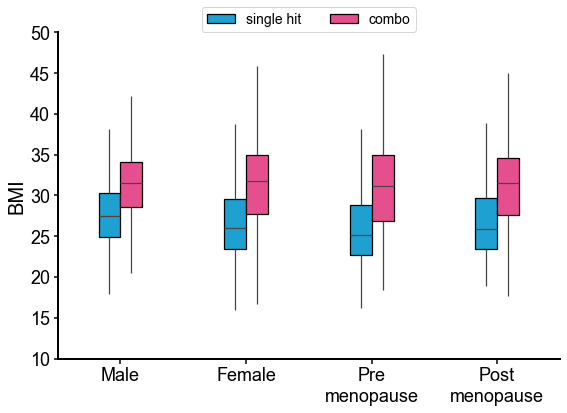

In [27]:
boxdf = oligo_table

fig,ax = plt.subplots(figsize=(9, 6))

# Box Plot
sns_ax = sns.boxplot(
    data=boxdf,
    palette=["#00ADEE", "#FF3688"],  # "#eecc16", "#008176" '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    x="group",
    y="bmi",
    hue="mutation",
    color="k",
    orient="v",
    legend=True,
    width=0.35, linewidth=1.25, fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'} #'facecolor':'none', 
    )

# Adjust Axis
# ax.set_yticks([-0.02, 0, 0.02, 0.04])
ax.set_ylim((10, 50))
# ax.set_ylabel('Percentage')
ax.set_xticklabels(["Male", "Female", "Pre\nmenopause", "Post\nmenopause"], rotation=0, fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("BMI", fontsize=20)

# Remove Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

# legend below as multiple columns
h,l = sns_ax.axes.get_legend_handles_labels()
sns_ax.axes.legend_.remove()
sns_ax.legend(h,l, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.1), fontsize=14)

In [26]:
for g in groups:
    print(f"Running t-test for {g}")
    single_hit_g = oligo_table.loc[(oligo_table.mutation=="single hit")&(oligo_table.group==g)]
    combo_hit_g = oligo_table.loc[(oligo_table.mutation=="combo")&(oligo_table.group==g)]
    ttest_res = ttest_ind(single_hit_g.bmi, combo_hit_g.bmi, alternative="less")
    print(f"TTest results:\tStatistics={ttest_res[0]};p-val={ttest_res[1]}")

Running t-test for british_male
TTest results:	Statistics=-17.446447554057197;p-val=2.085764514709077e-67
Running t-test for british_female
TTest results:	Statistics=-42.1537667201943;p-val=0.0
Running t-test for pre_menopause
TTest results:	Statistics=-33.35000962518566;p-val=4.961630814223802e-226
Running t-test for post_menopause
TTest results:	Statistics=-12.183599035132143;p-val=3.6293014440935692e-34


In [ ]:
ttest_ind(single_hit_pheno_c2.bmi, combo_hit_pheno_c2.bmi, alternative="less"), kstest(single_hit_pheno_c2.bmi, combo_hit_pheno_c2.bmi)

(Ttest_indResult(statistic=-10.400470428015863, pvalue=1.4621164126916534e-25),
 KstestResult(statistic=0.32861802904881665, pvalue=8.849310932759738e-24))

In [ ]:
ttest_ind(single_hit_pheno_c3.bmi, combo_hit_pheno_c3.bmi, alternative="less"), kstest(single_hit_pheno_c3.bmi, combo_hit_pheno_c3.bmi)

(Ttest_indResult(statistic=-26.510898062286397, pvalue=8.810889200687164e-155),
 KstestResult(statistic=0.4330296110581548, pvalue=2.5767301611682205e-149))